In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# Load the dataset
df = pd.read_excel('health.xlsx')

# Explore initial data
print(df.head())
print(df.info())
print(df.describe())

         PatientId  AppointmentID Gender ScheduledDay AppointmentDay  Age  \
0   29872499824296        5642903      F   2016-04-29     2016-04-29   62   
1  558997776694438        5642503      M   2016-04-29     2016-04-29   56   
2    4262962299951        5642549      F   2016-04-29     2016-04-29   62   
3     867951213174        5642828      F   2016-04-29     2016-04-29    8   
4    8841186448183        5642494      F   2016-04-29     2016-04-29   56   

       Neighbourhood  Scholarship  Hipertension  Diabetes  Alcoholism  \
0    JARDIM DA PENHA        False          True     False       False   
1    JARDIM DA PENHA        False         False     False       False   
2      MATA DA PRAIA        False         False     False       False   
3  PONTAL DE CAMBURI        False         False     False       False   
4    JARDIM DA PENHA        False          True      True       False   

   Handcap  SMS_received  Showed_up  Date.diff  
0    False         False       True          0  


In [21]:
# Check for missing values
print(df.isnull().sum())

# Handle missing values if any (this dataset appears clean)
# df = df.dropna()  # if needed

# Convert boolean columns to numeric
bool_cols = ['Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'Showed_up']
df[bool_cols] = df[bool_cols].astype(int)

# Convert dates to datetime objects
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

# Extract day of week features
df['ScheduledDayOfWeek'] = df['ScheduledDay'].dt.dayofweek
df['AppointmentDayOfWeek'] = df['AppointmentDay'].dt.dayofweek

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
Showed_up         0
Date.diff         0
dtype: int64


In [31]:
# Show-up vs no-show rates
print(df['Showed_up'].value_counts(normalize=True))

# Analyze by different features
for col in ['Gender', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'SMS_received']:
    print(f"\nShow-up rate by {col}:")
    print(df.groupby(col)['Showed_up'].mean())

Showed_up
1    0.789474
0    0.210526
Name: proportion, dtype: float64

Show-up rate by Gender:
Gender
F    0.80
M    0.75
Name: Showed_up, dtype: float64

Show-up rate by Scholarship:
Scholarship
0    0.812500
1    0.666667
Name: Showed_up, dtype: float64

Show-up rate by Hipertension:
Hipertension
0    0.75
1    1.00
Name: Showed_up, dtype: float64

Show-up rate by Diabetes:
Diabetes
0    0.777778
1    1.000000
Name: Showed_up, dtype: float64

Show-up rate by Alcoholism:
Alcoholism
0    0.789474
Name: Showed_up, dtype: float64

Show-up rate by SMS_received:
SMS_received
0    0.812500
1    0.666667
Name: Showed_up, dtype: float64


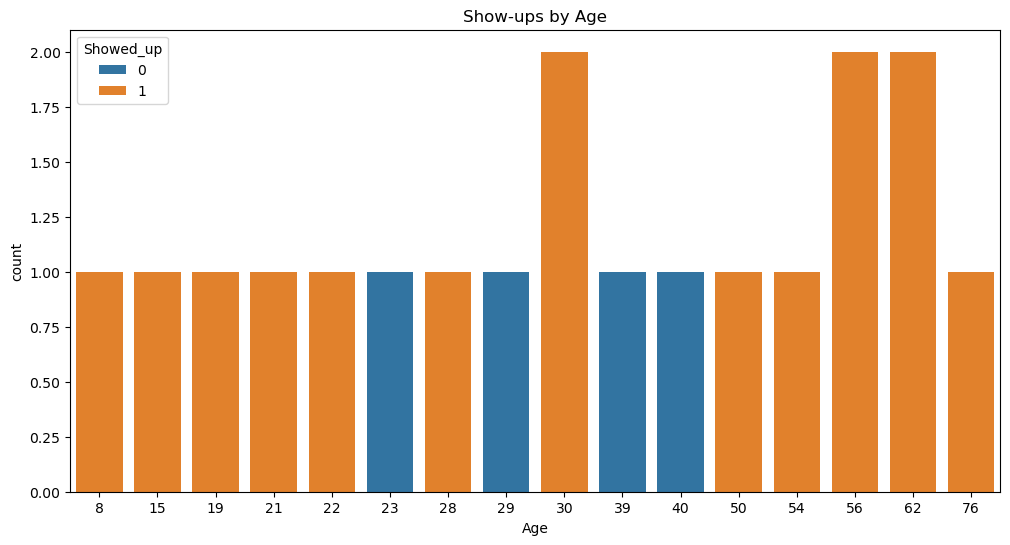

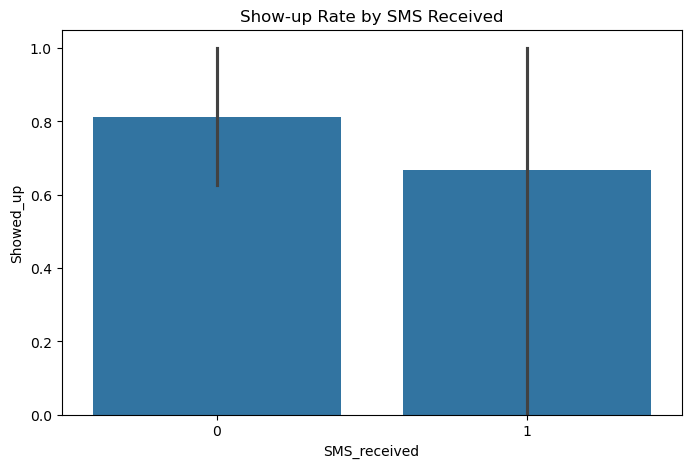

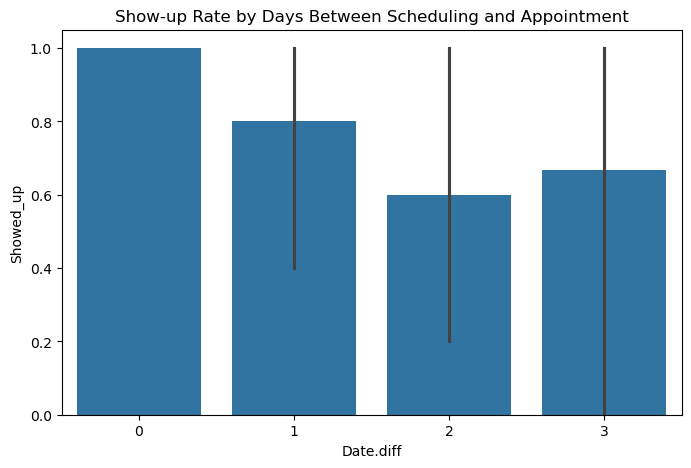

In [33]:
# Plot show-up rates by different factors
plt.figure(figsize=(12, 6))
sns.countplot(x='Age', hue='Showed_up', data=df)
plt.title('Show-ups by Age')
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(x='SMS_received', y='Showed_up', data=df)
plt.title('Show-up Rate by SMS Received')
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(x='Date.diff', y='Showed_up', data=df)
plt.title('Show-up Rate by Days Between Scheduling and Appointment')
plt.show()

In [35]:
# Create age groups
bins = [0, 18, 35, 50, 65, 100]
labels = ['0-18', '19-35', '36-50', '51-65', '65+']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)

# Create binary feature for same-day appointments
df['SameDay'] = (df['Date.diff'] == 0).astype(int)

# Create feature for number of health conditions
df['NumConditions'] = df[['Hipertension', 'Diabetes', 'Alcoholism']].sum(axis=1)

In [37]:
# Select features and target
features = ['Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 
            'Alcoholism', 'Handcap', 'SMS_received', 'Date.diff',
            'ScheduledDayOfWeek', 'AppointmentDayOfWeek', 'SameDay', 'NumConditions']
X = pd.get_dummies(df[features], drop_first=True)
y = df['Showed_up']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Initialize and train model
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions
y_pred = dt_model.predict(X_test)

In [41]:
# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:\n", feature_importance)

Accuracy: 0.75

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.75      1.00      0.86         3

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4


Confusion Matrix:
 [[0 1]
 [0 3]]

Feature Importance:
                  Feature  Importance
0                    Age         1.0
1            Scholarship         0.0
2           Hipertension         0.0
3               Diabetes         0.0
4             Alcoholism         0.0
5                Handcap         0.0
6           SMS_received         0.0
7              Date.diff         0.0
8     ScheduledDayOfWeek         0.0
9   AppointmentDayOfWeek         0.0
10               SameDay         0.0
11         NumConditions         0.0
12              Gender_M         0.0


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
# In your Python script, after cleaning and preprocessing:
df.to_excel('cleaned_health_data.xlsx', index=False)
